In [2]:
import numpy as np
import scipy as sc
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import itertools
import datetime
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = {}
for i in range(len(root_tweet_names)):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].fillna(0)
    tweet_df[['FollowerCount','UserId']] = tweet_df[['FollowerCount','UserId']].apply(pd.to_numeric, errors='coerce', downcast='integer')
    
    tweet_dfs[i] = tweet_df

In [5]:
tweet_name_to_index = {}
for i in range(len(root_tweet_names)):
    tweet_name_to_index[root_tweet_names[i]] = i
# for key in tweet_name_to_index.keys():
#     print key

In [6]:
def format_partition_file_name(name):
    root = name.split('.')
    items = root[0].split('_')
    items[-2], items[-1] = items[-1], items[-2]
    return ".".join(["_".join(items), root[-1]])

In [8]:
path = '../RetweetDataAOAS/Partition/'
partition_names = [f for f in listdir(path) if isfile(join(path, f))]
partitions = {}
# for i in range(len(partition_names)):
for i in range(1, 2):
    partitions[i] = {}
    print i
    partition_df = pd.read_excel(path+partition_names[i], encoding = "ISO-8859-1")
    for index, row in partition_df.iterrows():
        training_file_name = format_partition_file_name(row['Training'])
        prediction_file_name = format_partition_file_name(row['Prediction'])
        print "\n", training_file_name
        print prediction_file_name
        partitions[i][tweet_name_to_index[training_file_name]] = True
        partitions[i][tweet_name_to_index[prediction_file_name]] = False    

1

Source_followers_tweet_0022_Lawrence.txt
Source_followers_tweet_0024_pbsgwen.txt

Source_followers_tweet_0026_realMickFoley.txt
Source_followers_tweet_0028_AnnCoulter.txt

Source_followers_tweet_0031_ASAPYams.txt
Source_followers_tweet_0031_CNET.txt

Source_followers_tweet_0037_EvaLongoria.txt
Source_followers_tweet_0044_JonnyBones.txt

Source_followers_tweet_0048_MissInfoTV.txt
Source_followers_tweet_0068_CharlesMBlow.txt

Source_followers_tweet_0069_bobatl.txt
Source_followers_tweet_0070_E40.txt

Source_followers_tweet_0074_Tip.txt
Source_followers_tweet_0074_iamwill.txt

Source_followers_tweet_0085_MrChuckD.txt
Source_followers_tweet_0091_CharlesMBlow.txt

Source_followers_tweet_0092_AnnCoulter.txt
Source_followers_tweet_0092_jasonsegel.txt

Source_followers_tweet_0101_GarryShandling.txt
Source_followers_tweet_0101_Pitbull.txt

Source_followers_tweet_0101_myfabolouslife.txt
Source_followers_tweet_0107_djkhaled.txt

Source_followers_tweet_0108_newtgingrich.txt
Source_followers_twe

In [9]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

# modify the dfs accordingly
for i in range(len(root_tweet_names)):
    for index, row in tweet_dfs[i].iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_dfs[i].at[row['ParentDfIndex'],
                                                      'Time']
            tweet_dfs[i].loc[index,"ReactionTime"] = reaction_time
        else:
            tweet_dfs[i].loc[index,"ReactionTime"] = datetime.timedelta(seconds=0)

In [10]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet
        

In [11]:
tweet_df_1 = tweet_dfs[1]
s_j_x = sorted(generate_reaction_times(tweet_df_1).values())
log_s_j_x = [np.log(i.seconds) for i in s_j_x]
tweet_df_1_users = list(tweet_df_1['UserId'])
m_j_x_dic = generate_number_of_follower_who_retweet(tweet_df_1)
m_j_x_lis = []
for key in m_j_x_dic.keys():
    m_j_x_lis.append(m_j_x_dic[key])

In [13]:
tweet_dfs[1].iloc[0]["FollowerCount"]

40041.0

In [15]:
def get_m_x_t(x,sec):
    return len(tweet_dfs[x].loc[tweet_dfs[x]["ReactionTime"] < datetime.timedelta(seconds=sec)])

In [16]:
# linear regression model setup

t = []
m_x_t = []
M_x = []
F_x = []

t_test = []
m_x_t_test = []
M_x_test = []
F_x_test = []


for i in range(1,14):
    secs = int(np.floor(np.exp(i)))
    for x in range(len(root_tweet_names)):
#     for x in range(10):
        total_retweets = len(tweet_dfs[x])-1
        f = tweet_dfs[x].iloc[0]["FollowerCount"]
        if partitions[1][x]:
            t.append(i)
            m_x_t.append(get_m_x_t(x,secs))
            M_x.append(total_retweets)
            F_x.append(f)
        else:
            t_test.append(i)
            m_x_t_test.append(get_m_x_t(x,secs))
            M_x_test.append(total_retweets)
            F_x_test.append(f)
            

t = np.array(t)
M_x_log = np.log(np.array(M_x))
M_x_max = np.amax(M_x_log)
M_x_log = M_x_log #/ M_x_max

m_x_t = np.array(m_x_t)
m_x_t_log = np.log(m_x_t) #/M_x_max

m_x_t_test_log = np.log(np.array(m_x_t_test))#/M_x_max
M_x_test_log = np.log(np.array(M_x_test))#/M_x_max

F_x_log = np.log(np.array(F_x))
F_x_test_log = np.log(np.array(F_x_test))

In [19]:
# modified Szabo and Huberman: log(M^x) = beta_0 + beta_t*t + beta_m * log(m^x(t)) + beta_f * log(f^x) + e^x

with pm.Model() as follower_model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    beta_0 = pm.Normal('beta_0', mu = 0, sd=20)
    beta_t = pm.Normal('beta_t', mu = 0, sd=20)
    beta_m = pm.Normal('beta_m', mu = 0, sd=20)
    beta_f = pm.Normal('beta_f', mu = 0, sd=20)
        
    e_x = pm.Normal("e", mu = 0, sd = 1, shape = (len(t),1))

    # Define likelihood    
    likelihood = pm.Normal('y', mu=beta_0 + beta_t*t + beta_m*m_x_t_log + beta_f*F_x_log+ e_x,
                        sd=sigma, observed=M_x_log)

In [20]:
# Run and fit our model
with follower_model:
#     step = pm.Metropolis()
    trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [e, beta_f, beta_m, beta_t, beta_0, sigma_log__]
100%|██████████| 2000/2000 [03:53<00:00,  8.56it/s]
The acceptance probability does not match the target. It is 0.650694959087, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


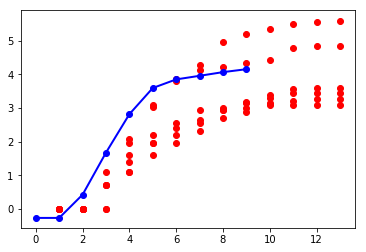

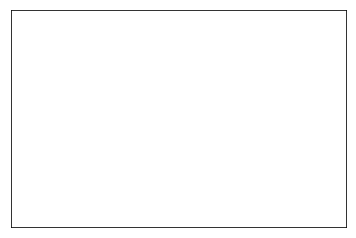

In [48]:
# Plot outputs

plt.scatter(t, m_x_t_log,  color='red')

b_t = np.mean(trace['beta_t'])
# b_1 = np.mean(trace['beta_1'])
x_line = [i for i in range(10)]
y_line = []
for val in x_line:
    y_line.append(b_t + m_x_t_log[6*val])

plt.plot(x_line, y_line, 'bo-', label='line 1', linewidth=2)
fig, ax = plt.subplots()

plt.xticks(())
plt.yticks(())

plt.show()

5.84064165737


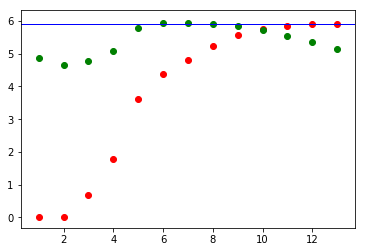

In [28]:
# plot a single retweet graph
# red is obsered
# blue is total retweeted
# green is prediction


j = 20

print M_x_log[j]

plt.scatter(t[j::26], m_x_t_test_log[j::26],  color='red')
plt.axhline(y = M_x_test_log[j], linewidth=1, color='blue')

pred = []
b_0 = np.mean(trace['beta_0'])
b_t = np.mean(trace['beta_t'])
b_m = np.mean(trace['beta_m'])
b_f = np.mean(trace['beta_f'])

for i in range(1,14):
#     print i, 26*(i-1)+j
#     pred.append(max(b_0 + b_t*i + b_m * m_x_t_test_log[26*(i-1)+j],m_x_t_test_log[26*(i-1)+j]))
    pred.append((b_0 + b_t*i + b_m * m_x_t_test_log[26*(i-1)+j] + b_f*F_x_test_log[j]) )
    
# print t[j::26]
# print pred
    
plt.scatter(t[j::26], pred,  color='green')

plt.show()

3.63718330478
-0.221803032906
0.493721892227
0.0974704593839


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22a98dde90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f22a3ea9410>]], dtype=object)

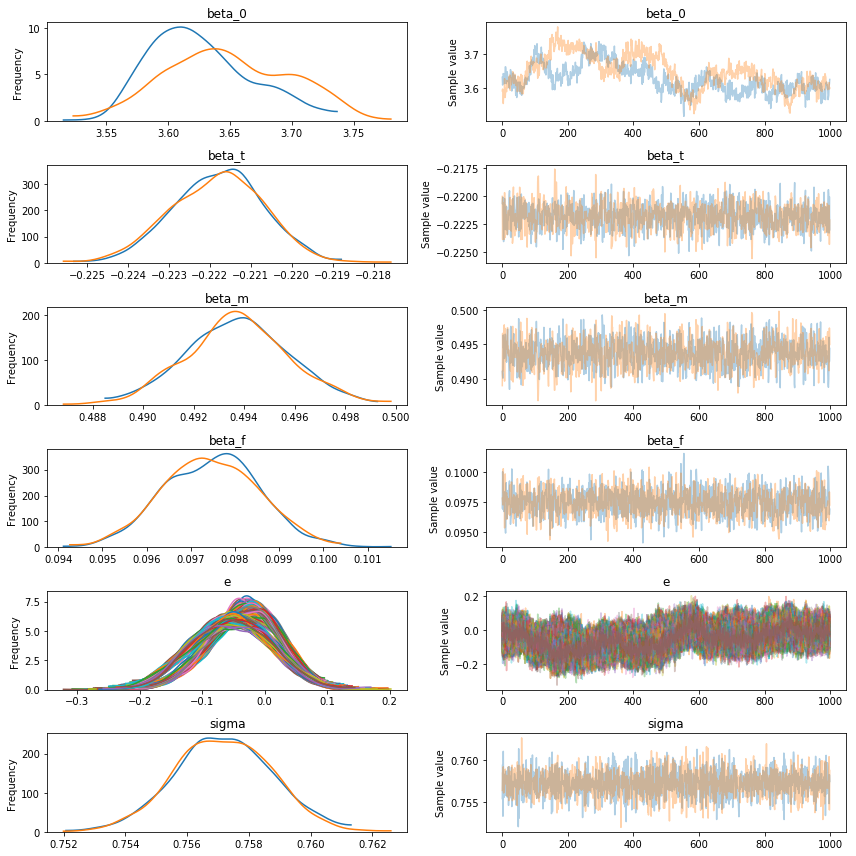

In [22]:
print np.mean(trace['beta_0'])
print np.mean(trace['beta_t'])
print np.mean(trace['beta_m'])
print np.mean(trace['beta_f'])
pm.traceplot(trace)